In [63]:
from Circuit import Circuit
from Circuit_ops import zero_state, apply, state_prob_plot
from Circuit_ops import find_fidelities, plot_fidelities, save_fidelities, read_fidelities
from Circuit_ops import find_prob, plot_prob
from Circuit_ops import int_to_bit_str, bit_str_to_int
from Error_dist import error_dist
import time
from numpy import *
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt

In [158]:
N = 3

# Note: Configure Z to be a native gate
def sandwich_circuit(t, runs, inverted):
    
    circ = Circuit(N)
    circ.init_state = zero_state(N)
    circ.runs = runs
    circ.Z_is_native = True
    
    # First CNOT
    for i in range(N-1):
        circ.Y(i, t).XX(i, N-1, t).X(i, -t).X(N-1, -t).Y(i, -t)
    
    # Middle phase gate
    circ.Z(N-1, 0)
    
    # Second CNOT
    if inverted:
        for i in range(N-1):
            circ.Y(N-i-2, t).X(N-1, t).X(N-i-2, t).XX(N-i-2, N-1, -t).Y(N-i-2, -t)
    else:
        for i in range(N-1):
            circ.Y(N-i-2, t).XX(N-i-2, N-1, t).X(N-i-2, -t).X(N-1, -t).Y(N-i-2, -t)
    
    # Compile "noisy" gates for many parallel circuit runs
    circ.compute()
    
    return circ
    
def parallel_circ(t, s_range, inverted=True):
        
    runs = len(s_range)
    circ = sandwich_circuit(t, runs, inverted)

    # Edit noisy gates
    gate_angles = array([])
    
    for k in range(runs):
        gate_angles = s_range
        
    # Find index of Z gate
    Z_gate_index = [i for i, gate in enumerate(circ.ideal_gates) if gate[0] == 'Z'][0]
    
    # Variable gate angle for middle Z gate
    # Note: this works because num of "ideal_gates" = num of "noisy_gates"
    circ.noisy_gates[Z_gate_index][2][0] = gate_angles

    return circ

def run_parallel_circ(err, s_range):
    start = time.time()
    
    circ0 = parallel_circ(pi/2, s_range)
    ideal_states = circ0.compute(compile_gates=False)
    
    circ1 = parallel_circ(pi/2 * (1 + err), s_range)
    final_states1 = circ1.compute(compile_gates=False)
    
    circ2 = parallel_circ(pi/2 * (1 + err), s_range, inverted=False)
    final_states2 = circ2.compute(compile_gates=False)
    
#     for gate in circ2.ideal_gates:
#         print(gate)
#     print(len(final_states2))
    
    fidelities1 = find_fidelities(final_states1, ideal_states)
    fidelities2 = find_fidelities(final_states2, ideal_states)
    
    plt.title(f'Fidelity for over-rotation = {err}')
    plt.ylabel('Fidelity')
    plt.xlabel('Rotation angle for middle gate')
    plt.plot(s_range, fidelities1, label=f"N={N}, Inverted")
    plt.plot(s_range, fidelities2, label=f"N={N}, Not inverted")
    plt.legend(loc=1)
    
    print(f'Time elapsed = {time.time() - start}')
    
    return fidelities1, fidelities2

Time elapsed = 0.029532909393310547


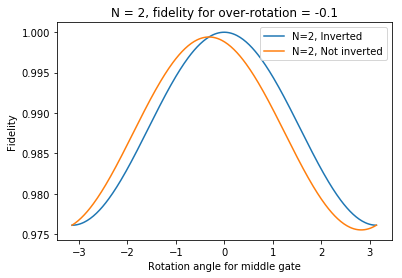

In [153]:
N = 2

err = -0.1
runs = 300

_ = run_parallel_circ(err, s_range=linspace(-pi, pi, runs))

Time elapsed = 0.02914905548095703


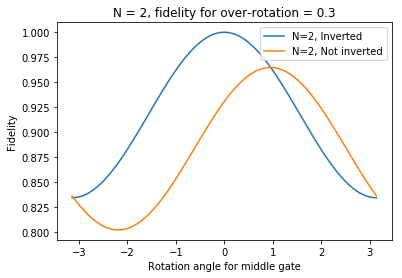

In [154]:
N = 2

err = 0.3
runs = 300

_ = run_parallel_circ(err, s_range=linspace(-pi, pi, runs))

Time elapsed = 0.043885231018066406
Time elapsed = 0.05022597312927246
Time elapsed = 0.09025096893310547
Time elapsed = 0.16469216346740723
Time elapsed = 0.3231828212738037


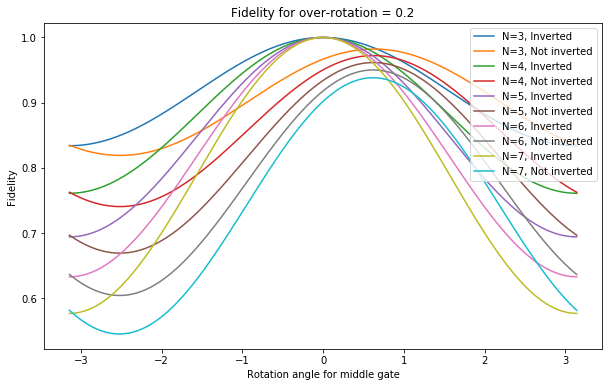

In [159]:
plt.figure(figsize=(10,6))
for i in range(3, 8):
    N = i

    err = 0.2
    runs = 400

    _ = run_parallel_circ(err, s_range=linspace(-pi, pi, runs))